# Ejemplo de Regresión lineal

**Autor**: Alejandro Alonso Puig + ChatGPT-5

**Fecha**: Octubre 2025

**Licencia**: Apache 2.0

### Objetivos

En este cuaderno vamos a aplicar un modelo de **regresión lineal** utilizando Python y scikit-learn. El objetivo es predecir una variable continua a partir de otras características numéricas, siguiendo el ciclo habitual de trabajo en machine learning.

A lo largo del cuaderno realizaremos los siguientes pasos:

1. Cargar un conjunto de datos real de ejemplo.
2. Explorar brevemente los datos y verificar si requieren preprocesamiento.
3. Dividir el conjunto en datos de entrenamiento y prueba.
4. Crear y entrenar un modelo de regresión lineal.
5. Evaluar el rendimiento del modelo con métricas como RMSE y R².
6. Guardar y reutilizar el modelo para hacer nuevas predicciones.


### Preparación del entorno

Importamos las librerías necesarias para todo el proceso: manipulación de datos, modelos de regresión, métricas y guardado del modelo.

In [2]:
import numpy as np                                                  # Operaciones numéricas
import pandas as pd                                                 # Manipulación de DataFrames
from sklearn.datasets import load_diabetes                          # Dataset clásico de regresión
from sklearn.model_selection import train_test_split, GridSearchCV  # División y búsqueda de hiperparámetros
from sklearn.preprocessing import StandardScaler                    # Escalado de datos
from sklearn.linear_model import LinearRegression, Ridge            # Modelos
from sklearn.pipeline import Pipeline                               # Pipeline: escalado + modelo
from sklearn.metrics import mean_squared_error, r2_score            # Métricas
import joblib                                                       # Guardado/carga del modelo


### Recolección de datos

Usamos un dataset incluido en scikit-learn: `diabetes`, con variables numéricas y un target continuo.

In [3]:
data = load_diabetes(as_frame=True)       # Carga como DataFrame
X = data.data                             # Variables de entrada
y = data.target                           # Variable objetivo


### Análisis y preprocesamiento de datos

#### Análisis inicial del dataset

Antes de entrenar un modelo, conviene responder a preguntas como:

*   ¿Faltan datos?
*   ¿Hay variables con escalas muy distintas?
*   ¿Hay outliers evidentes?
*   ¿Es necesario normalizar o escalar?
*   ¿Todas las variables son numéricas?

**Visualizar las primeras filas**. sirve para:

- Verificar que los datos se han cargado correctamente
- Entender la estructura del dataset (columnas, tipos de datos, escalas)
- Detectar posibles valores atípicos o faltantes al primer vistazo

Es un paso básico antes de cualquier análisis o modelado.

In [13]:
# Análisis inicial del dataset
print("Dimensiones del dataset:", X.shape)  # Tamaño del conjunto de datos
print("\nPrimeras filas de X:")
display(X.head())                           # Muestra las primeras filas de datos
print("\nPrimeras filas de y:")
display(y.head())                           # Muestra las primeras filas de datos



Dimensiones del dataset: (442, 10)

Primeras filas de X:


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641



Primeras filas de y:


,target
0,151.0
1,75.0
2,141.0
3,206.0
4,135.0


Cada fila representa a un paciente, y las columnas son variables

| Variable | Significado aproximado                        |
| -------- | --------------------------------------------- |
| `age`    | Edad del paciente (normalizada)               |
| `sex`    | Sexo (codificado como -0.0446 o 0.0506)       |
| `bmi`    | Índice de masa corporal                       |
| `bp`     | Presión arterial promedio                     |
| `s1`     | Colesterol total en sangre (probable)         |
| `s2`     | LDL (colesterol “malo”)                       |
| `s3`     | HDL (colesterol “bueno”)                      |
| `s4`     | Relación entre colesterol total y HDL         |
| `s5`     | Niveles de azúcar en sangre (similar a HbA1c) |
| `s6`     | Nivel de insulina o similar                   |

| Variable | Significado aproximado                        |
| -------- | --------------------------------------------- |
| `target` | Progresión de la diabetes un año después (medida continua, derivada de datos clínicos como evolución de glucosa, complicaciones, etc.) |



**Verificar valores nulos**
Verificamos valores nulos para evitar errores durante el entrenamiento y asegurar que el modelo trabaje con datos completos y consistentes.

In [10]:
print("\nCantidad de valores nulos por variable:")
print(X.isnull().sum())                     # Comprueba valores faltantes



Cantidad de valores nulos por variable:
age    0
sex    0
bmi    0
bp     0
s1     0
s2     0
s3     0
s4     0
s5     0
s6     0
dtype: int64


**Histograma de distribución de las variables**

Esto permite ver si los datos están centrados, si hay sesgo o outliers visuales. Si aparecen variables con distribuciones muy asimétricas, valores extremos o escalas diferentes, conviene considerar normalización o transformación logarítmica.

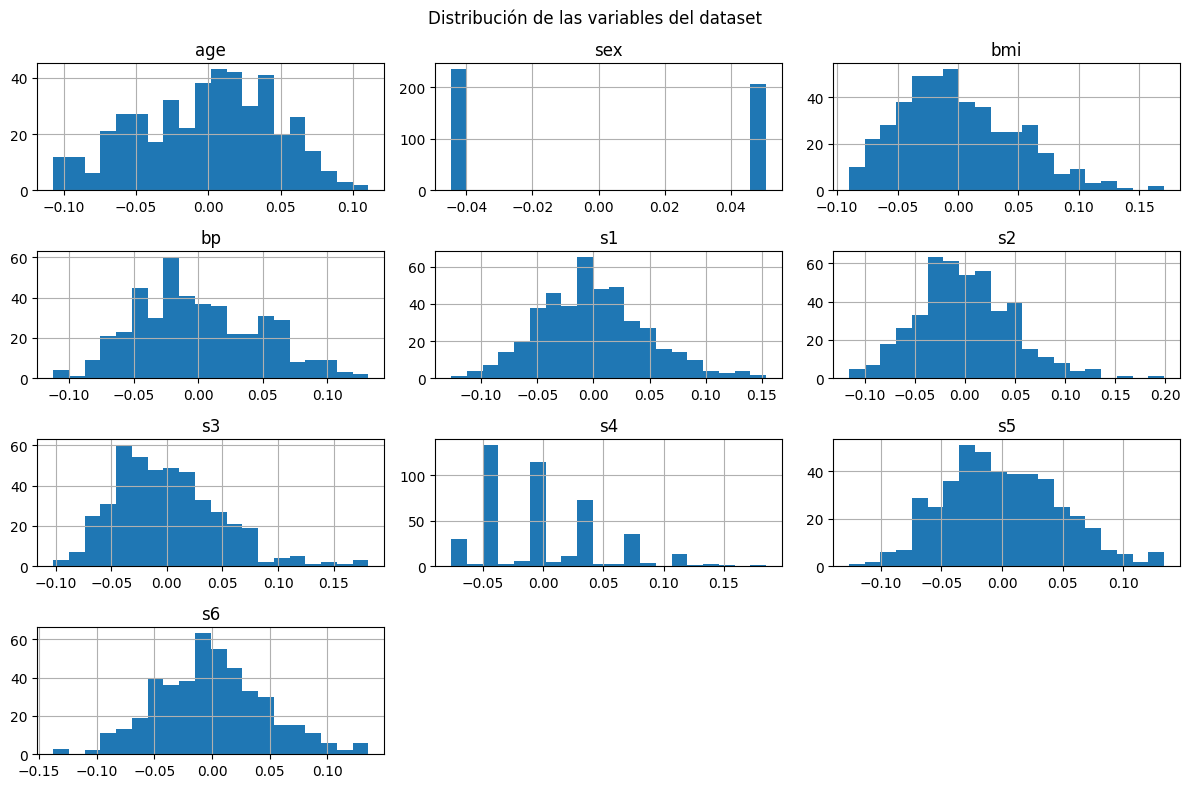

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

X.hist(bins=20, figsize=(12, 8))  # Histograma por variable
plt.suptitle("Distribución de las variables del dataset")
plt.tight_layout()
plt.show()


*Observaciones: La mayoría de las variables están razonablemente distribuidas, pero es importante detectar casos como sex (binaria) y s4 (discreta o problemática). Además, variables muy correlacionadas como s1 y s2 podrían causar redundancia. Todo esto debe revisarse antes de entrenar un modelo para evitar errores y mejorar la precisión.*

**Mapa de calor de correlaciones**

Esto te permite ver si hay variables muy correlacionadas, lo cual puede influir en la regresión.
Si hay pares de variables con correlación cercana a 1 o -1, puede que estén aportando información redundante.

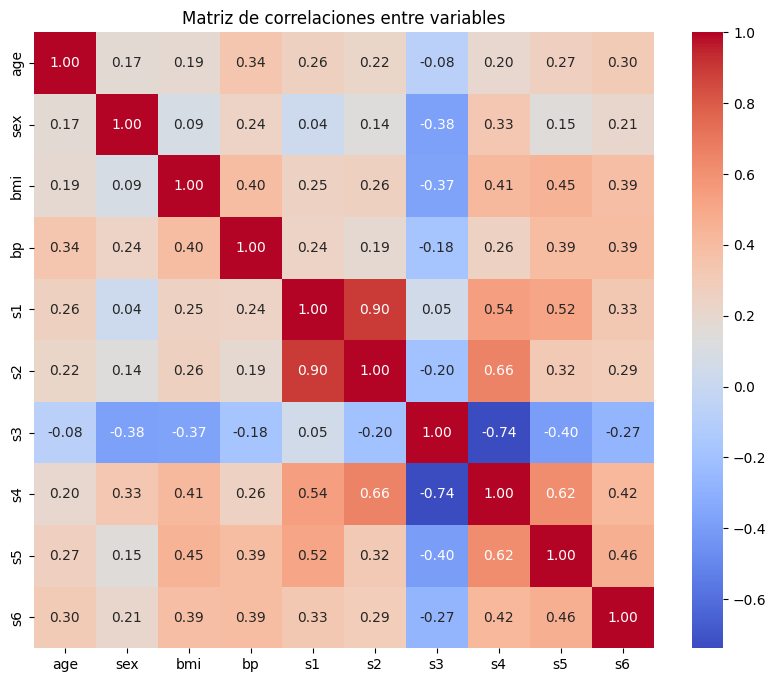

In [7]:
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de correlaciones entre variables")
plt.show()


*Observaciones: Hemos detectado que las variables S1 y S2 están altamente correlacionadas (r = 0.9), lo que sugiere que aportan información redundante.
Aunque en regresión lineal simple esto no es crítico, en modelos más complejos (como regresión múltiple o regularizada) puede generar problemas dificultando la interpretación.*

####Preprocesamiento

Dado que los datos ya están normalizados y no presentan valores nulos ni atípicos evidentes, y al ser un ejemplo sencillo de regresión lineal, podemos obviar el preprocesamiento adicional y proceder directamente al entrenamiento del modelo.

### División de los datos

X contiene las variables predictoras normalizadas del paciente y y contiene un valor numérico que representa la progresión de la diabetes un año después.

Dividimos el conjunto total en entrenamiento (80%) y test (20%).

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)


### Entrenamiento del modelo

Antes de entrenar el modelo, agrupamos varios pasos en un solo flujo usando un pipeline. Un pipeline nos permite encadenar operaciones de preprocesamiento y entrenamiento, asegurando que se apliquen siempre en el mismo orden y evitando errores.

Primero, normalizamos los datos usando `StandardScaler`, que ajusta cada variable para que tenga media 0 y desviación típica 1. Esto es útil porque muchas técnicas de aprendizaje automático (como la regresión) funcionan mejor si las variables están en la misma escala.

Luego aplicamos una regresión lineal con `LinearRegression`, que intenta encontrar la línea (o plano) que mejor se ajusta a los datos para predecir el resultado.

In [14]:
pipe = Pipeline([
    ("scaler", StandardScaler()),         # Normaliza las características (media 0, desviación típica 1)
    ("model", LinearRegression())         # Modelo de regresión lineal
])

pipe.fit(X_train, y_train)               # Entrenamiento del modelo con los datos de entrenamiento


Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

Este pipeline aplica automáticamente el escalado antes de entrenar, y también lo aplicará a cualquier dato nuevo que queramos predecir.

### Evaluación

Una vez entrenado el modelo, es importante saber qué tal funciona con datos nuevos. Para ello usamos el conjunto de prueba (X_test), que el modelo no ha visto antes.

Calculamos dos métricas comunes:

- RMSE (Root Mean Squared Error): mide cuánto se equivocan las predicciones, en la misma unidad que la variable a predecir. Cuanto más bajo, mejor.

- R² (coeficiente de determinación): indica qué parte de la variabilidad del resultado se explica por el modelo. Toma valores entre 0 y 1 (siendo 1 un modelo perfecto).

En versiones anteriores de scikit-learn, la función mean_squared_error no acepta el parámetro squared=False, por lo que debemos calcular la raíz cuadrada manualmente.


In [16]:
y_pred = pipe.predict(X_test)                         # Predicción sobre el conjunto de prueba

rmse = np.sqrt(mean_squared_error(y_test, y_pred))    # Raíz del error cuadrático medio
r2 = r2_score(y_test, y_pred)                         # Coeficiente de determinación

print("RMSE:", rmse)
print("R²:", r2)



RMSE: 53.85344583676592
R²: 0.4526027629719197


Conclusiones: Un R² de 0.45 indica que el modelo captura parte de la variabilidad, pero más de la mitad queda sin explicar. Esto sugiere que:

- Puede que la relación entre las variables no sea puramente lineal.

- Puede que haya interacciones o transformaciones necesarias.

- Puede que falten variables relevantes.

El RMSE es relativamente alto respecto a los valores típicos de la variable objetivo (puedes comprobarlo mirando el histograma). Esto también indica que hay bastante error en las predicciones.

La regresión lineal sirve para empezar y entender el proceso de entrenamiento y evaluación, pero no siempre es suficiente. Probar con modelos más complejos (como árboles de decisión, regresión polinómica o modelos basados en aprendizaje automático) podría mejorar significativamente los resultados.

### Guardar el modelo

A veces queremos guardar el modelo tras entrenarlo, para poder usarlo más tarde sin necesidad de volver a entrenarlo (por ejemplo, en una aplicación web o en otro notebook).

Guardar modelo:

In [22]:
joblib.dump(pipe, "modelo_regresion.pkl")   # Guarda el pipeline en un archivo

['modelo_regresion.pkl']

Cargar modelo:

In [25]:
modelo_cargado = joblib.load("modelo_regresion.pkl")      # Carga el modelo desde el archivo

### Uso del modelo

Una vez cargado, el modelo puede usarse directamente para hacer predicciones sobre nuevos datos sin necesidad de reentrenarlo.


In [26]:
nuevas_predicciones = modelo_cargado.predict(X_test[:5])  # Predice con los primeros 5 casos de prueba
print(nuevas_predicciones)

[139.5475584  179.51720835 134.03875572 291.41702925 123.78965872]
